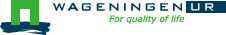



# An Jupyter notebook for running PCSE/WOFOST on a CGMS8 database

This Jupyter notebook will demonstrate how to connect and read data from a CGMS8 database for a single grid. Next the data will be used to run a PCSE/WOFOST simulation for potential and water-limited conditions, the latter is done for all soil types present in the selected grid. Results are visualized and exported to an Excel file.

Note that no attempt is made to *write* data to a CGMS8 database as writing data to a CGMS database can be tricky and slow. In our experience it is better to first dump simulation results to a CSV file and use specialized loading tools for loading  data into the database such as [SQLLoader](http://www.oracle.com/technetwork/database/enterprise-edition/sql-loader-overview-095816.html) for ORACLE or [pgloader](http://pgloader.io/) for PostgreSQL databases.

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST on a CGMS8 database:

  1. PCSE and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The database client software for the database that will be used, this depends on your database of choice. For SQLite no client software is needed as it is included with python. For Oracle you will need the [Oracle client software](http://www.oracle.com/technetwork/database/features/instant-client/index-097480.html) as well as the [python bindings for the Oracle client (cx_Oracle)](http://sourceforge.net/projects/cx-oracle/files/)). See [here](https://wiki.python.org/moin/DatabaseInterfaces) for an overview of database connectors for python;
  3. The `pandas` module for processing and visualizing WOFOST output;
  4. The `matplotlib` module, although we will mainly use it through pandas; 

## Importing the relevant modules

First the required modules need to be imported. These include the CGMS8 data providers for PCSE as well as other relevant modules.

In [2]:
%matplotlib inline
from pcse.db.cgms8 import GridWeatherDataProvider, AgroManagementDataProvider, SoilDataIterator, \
    CropDataProvider, STU_Suitability, SiteDataProvider
from pcse.models import Wofost71_WLP_FD, Wofost71_PP
from pcse.util import DummySoilDataProvider, WOFOST71SiteDataProvider
from pcse.base_classes import ParameterProvider
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlalchemy as sa
import pandas as pd
plt.style.use('ggplot')

## Building the connection to a CGMS8 database

The connection to the database will be made using SQLAlchemy. This requires a database URL to be provided, the format of this URL depends on the database of choice. See the SQLAlchemy documentation on [database URLs](http://docs.sqlalchemy.org/en/latest/core/engines.html#database-urls) for the different database URL formats.

For this example we will use a database that was created for Anhui province in China. This database can be downloaded [here](https://wageningenur4-my.sharepoint.com/:u:/g/personal/allard_dewit_wur_nl/EdwuayKW2IhOp6zCYElA0zsB3NGxcKjZc2zE_JGfVPv89Q?e=oEgI9R).

In [4]:
cgms8_db = "d:/nobackup/CGMS8_Anhui/CGMS_Anhui_complete.db"
dbURL = "sqlite:///%s" % cgms8_db
engine = sa.create_engine(dbURL)

## Defining what should be simulated

For the simulation to run, some IDs must be provided that refer to the location (`grid_no`), crop type (`crop_no`) and year (`campaign_year`) for which the simulation should be carried out. These IDs refer to identifiers in the CGMS database that are used to define the relationships.

In [5]:
grid_no = 81159
crop_no = 1  # Winter-wheat
campaign_year = 2008
# if input/output should be printed set show_results=True
show_results = True

## Retrieving data for the simulation from the database

### Weather data

Weather data will be derived from the GRID_WEATHER table in the database. By default, the entire time-series of weather data available for this grid cell will be fetched from the database.

In [6]:
weatherdata = GridWeatherDataProvider(engine, grid_no)
wdc = weatherdata("20080701")
if show_results:
    print(wdc)

Weather data for 2008-07-01 (DAY)
IRRAD:  21278000.00  J/m2/day
 TMIN:        24.81   Celsius
 TMAX:        32.56   Celsius
  VAP:        30.78       hPa
 RAIN:         0.36    cm/day
   E0:         0.63    cm/day
  ES0:         0.56    cm/day
  ET0:         0.49    cm/day
 WIND:         1.69     m/sec
Latitude  (LAT):    33.17 degr.
Longitude (LON):   116.33 degr.
Elevation (ELEV):   29.0 m.



### Agromanagement information

Agromanagement in CGMS mainly refers to the cropping calendar for the given crop and location.

In [7]:
agromanagement = AgroManagementDataProvider(engine, grid_no, crop_no, campaign_year)
agromanagement

[{datetime.date(2008, 10, 21): {'CropCalendar': {'crop_end_date': None,
    'crop_end_type': 'maturity',
    'crop_name': 'winter wheat',
    'crop_start_date': datetime.date(2008, 10, 21),
    'crop_start_type': 'sowing',
    'max_duration': 270,
    'variety_name': 'winter wheat_81159_2008'},
   'StateEvents': None,
   'TimedEvents': None}},
 {datetime.date(2009, 7, 18): None}]

### Soil information

A CGMS grid cell can contain multiple soils which may or may not be suitable for a particular crop. Therefore, fetching soil information works in two steps:
 1. First of all the `SoilDataIterator` will fetch all soil information for the given grid cell. It presents it as a list in such a way that the system can iterate over the different soils.
 2. Second, the `STU_Suitability` will contain all soils that are suitable for a given crop. The 'STU_NO' of each crop can be used to check if a particular STU is suitable for that crop.

In [15]:
soil_iterator = SoilDataIterator(engine, grid_no)
soil_iterator

[(4339,
  624551150.2622,
  11739,
  100,
  {'CRAIRC': 0.06,
   'K0': 10.7999,
   'KSUB': 10.0,
   'RDMSOL': 108.0,
   'SM0': 0.41,
   'SMFCF': 0.3,
   'SMLIM': 0.3,
   'SMW': 0.15,
   'SOPE': 10.0})]

In [16]:
suitable_stu = STU_Suitability(engine, crop_no)

### Crop parameters

Crop parameters are needed for parameterizing the crop simulation model. The `CropDataProvider` will retrieve them from the database for the given crop_no, grid_no and campaign_year.

In [11]:
cropd = CropDataProvider(engine, grid_no, crop_no, campaign_year)
if show_results:
    print(cropd)

Crop parameter values for grid_no=81159, crop_no=1 (winter wheat), variety_no=55, campaign_year=2008 derived from sqlite:///d:/nobackup/CGMS8_Anhui/CGMS_Anhui_complete.db
Single parameter values:
Par_code      Value  Par_code    Value
----------  -------  ----------  ------------
CFET          1      CRPNAM      winter wheat
CVL           0.685  CVO         0.709
CVR           0.694  CVS         0.662
DEPNR         4.5    DLC         10.0
DLO          13.5    DVSEND      2.0
DVSI          0      IAIRDU      0.0
IDSL          1      IOX         0
LAIEM         0.138  PERDL       0.03
Q10           2      RDI         10.0
RDMCR       125      RGRLAI      0.0082
RML           0.03   RMO         0.01
RMR           0.015  RMS         0.015
RRI           1.2    SPA         0.0
SPAN         23.5    TBASE       0.0
TBASEM        0      TDWI        195.0
TEFFMX       30      TSUM1       794.0
TSUM2       715      TSUMEM      100.0
Tabular parameters:
Par_code    Value
----------  --------------

### Site parameters

Site parameters are an ancillary class of parameters that are related to a given site. For example, an important parameter is the initial amount of moisture in the soil profile (WAV) and the Atmospheric CO2 concentration (CO2). Site parameters will be fetched for each soil type within the soil iteration loop.

## Simulating with WOFOST

### Place holders for storing simulation results

In [12]:
daily_results = {}
summary_results = {}

### Potential production

In [13]:
# For potential production we can provide site data directly
sited = WOFOST71SiteDataProvider(CO2=360, WAV=25)
# We do not need soildata for potential production so we provide some dummy values here
soild = DummySoilDataProvider()
# Start WOFOST, run the simulation 
parameters = ParameterProvider(sitedata=sited, soildata=soild, cropdata=cropd)
wofost = Wofost71_PP(parameters, weatherdata, agromanagement)
wofost.run_till_terminate()
# convert output to Pandas DataFrame and store it
daily_results['Potential'] = pd.DataFrame(wofost.get_output()).set_index("day")
summary_results['Potential'] = wofost.get_summary_output()

### Water-limited production

Water-limited simulations will be carried out for each soil type. First we will check that the soil type is suitable. Next we will retrieve the site data and run the simulation. Finally, we will collect the output and store the results. 

In [17]:
for smu_no, area, stu_no, percentage, soild in soil_iterator:
    # Check if this is a suitable STU
    if stu_no not in suitable_stu:
        continue
    # retrieve the site data for this soil type
    sited = SiteDataProvider(engine, grid_no, crop_no, campaign_year, stu_no)
    # Start WOFOST, run the simulation 
    parameters = ParameterProvider(sitedata=sited, soildata=soild, cropdata=cropd)
    wofost = Wofost71_WLP_FD(parameters, weatherdata, agromanagement)
    wofost.run_till_terminate()
    # Store simulation results
    runid = "smu_%s-stu_%s" % (smu_no, stu_no)
    daily_results[runid] = pd.DataFrame(wofost.get_output()).set_index("day")
    summary_results[runid] = wofost.get_summary_output()

## Visualizing and exporting simulation results

### We can visualize the simulation results using pandas and matplotlib

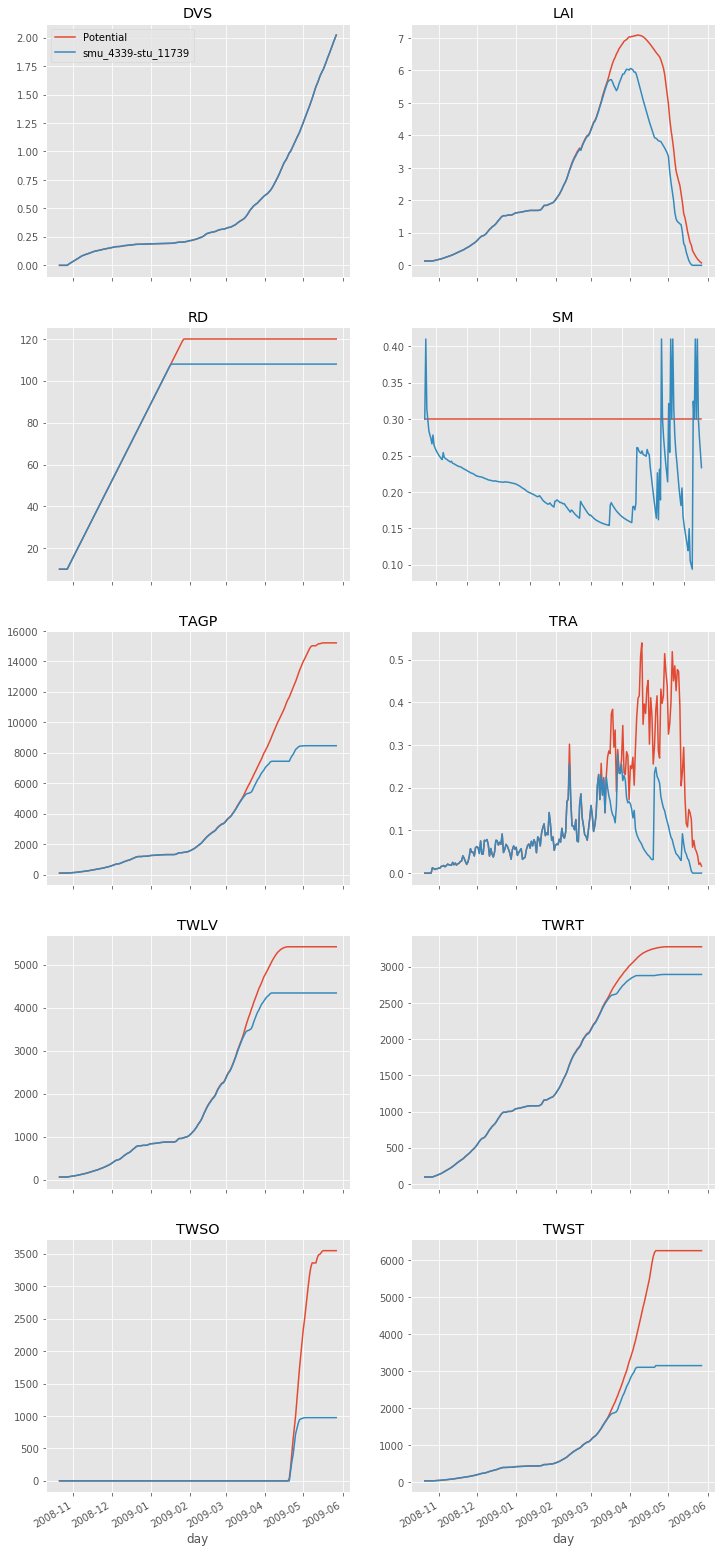

In [18]:
# Generate a figure with 10 subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 30))
# Plot results
for runid, results in daily_results.iteritems():
    for var, ax in zip(results, axes.flatten()):
        results[var].plot(ax=ax, title=var, label=runid)
        ax.set_title(var)
fig.autofmt_xdate()
axes[0][0].legend(loc='upper left')

### Exporting the simulation results

A pandas DataFrame or panel can be easily export to a [variety of formats](http://pandas.pydata.org/pandas-docs/stable/io.html) including CSV, Excel or HDF5. First we convert the results to a Panel, next we will export to an Excel file. 

In [19]:
excel_fname = "d:/temp/cgms8_wofost_results.xls"
panel = pd.Panel(daily_results)
panel.to_excel(excel_fname)

## Simulating with a different start date waterbalance
By default CGMS starts the simulation when the crop is planted. Particularly in dry climates this can be problematic because the results become very sensitive to the initial value of the soil water balance. In such scenarios, it is more realistic to start the water balance with a dry soil profile well before the crop is planted and let the soil 'fill up' as a result of rainfall. 

To enable this option, the column `GIVEN_STARTDATE_WATBAL` in the table `INITIAL_SOIL_WATER` should be set to the right starting date for each grid_no, crop_no, year and stu_no. Moreover, the other parameters in the table should be set to the appropriate values (particularly the initial soil moisture `WAV`).

The start date of the water balance should then be used to update the agromanagement data during the simulation loop, see the example below.

In [20]:
for smu_no, area, stu_no, percentage, soild in soil_iterator:
    # Check if this is a suitable STU
    if stu_no not in suitable_stu:
        continue
    # retrieve the site data for this soil type
    sited = SiteDataProvider(engine, grid_no, crop_no, campaign_year, stu_no)
    # update the campaign start date in the agromanagement data
    agromanagement.set_campaign_start_date(sited.start_date_waterbalance)
    # Start WOFOST, run the simulation 
    parameters = ParameterProvider(sitedata=sited, soildata=soild, cropdata=cropd)
    wofost = Wofost71_WLP_FD(parameters, weatherdata, agromanagement)
    wofost.run_till_terminate()
    # Store simulation results
    runid = "smu_%s-stu_%s" % (smu_no, stu_no)
    daily_results[runid] = pd.DataFrame(wofost.get_output()).set_index("day")
    summary_results[runid] = wofost.get_summary_output()

## Let's show the results 

As you can see, the results from the simulation are slightly different because of a different start date of the water balance.

NOTE: the dates on the x-axis are the same except for the soil moisture chart 'SM' where the water-limited simulation results start before potential results. This is a matplotlib problem.

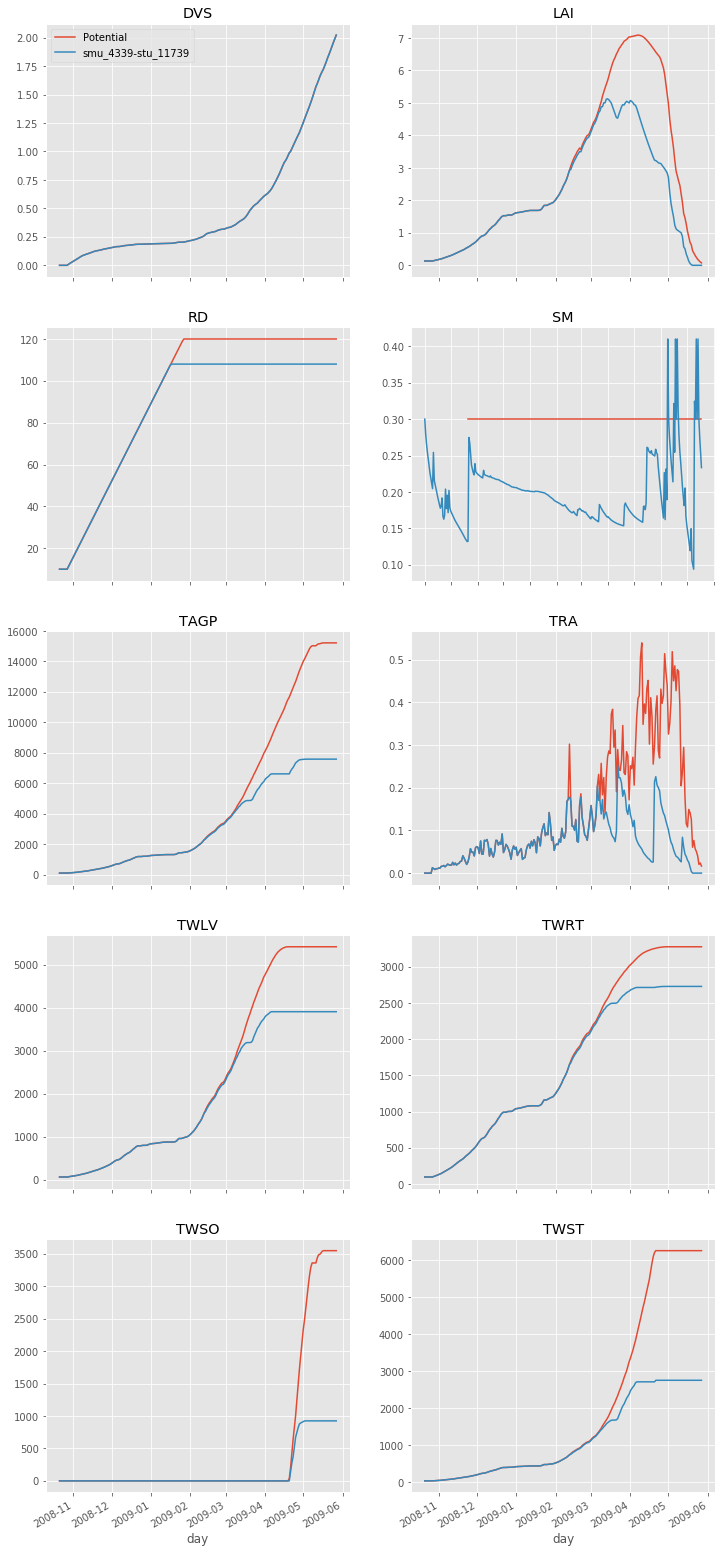

In [21]:
# Generate a figure with 10 subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 30))
# Plot results
for runid, results in daily_results.iteritems():
    for var, ax in zip(results, axes.flatten()):
        results[var].plot(ax=ax, title=var, label=runid)
fig.autofmt_xdate()
axes[0][0].legend(loc='upper left')